<a href="https://www.kaggle.com/code/zirklelc/micrograd?scriptVersionId=157179982" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

###  Titanic with MicroGrad

In [1]:
!pip install micrograd

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from micrograd.engine import Value
from micrograd.nn import MLP

%matplotlib inline

In [3]:
# Load train and test datasets
train_df = pd.read_csv("../input/titanic/train.csv", index_col="PassengerId")
test_df = pd.read_csv("../input/titanic/test.csv", index_col="PassengerId")

train_df.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Preprocess datasets
datasets = [train_df, test_df]

# Calculate the median age and fare from teh training dataset
median_age = train_df["Age"].median()
median_fare = train_df["Fare"].median()

# Iterate over both datasets
for dataset in datasets:
    # Fill NaNs for `Age` and `Fare` with the columns' median value.
    # Note to fill NaNs in the test dataset with the median values from the training dataset.
    dataset["Age"].fillna(median_age, inplace=True)
    dataset["Fare"].fillna(median_fare, inplace=True)

    # Convert `Sex` into categorical feature
    dataset["Sex"] = pd.Categorical(dataset["Sex"])
    dataset["Sex"] = dataset["Sex"].cat.codes

    # Note not to convert `Embarked` into a categorical feature here, because the training set missing values but the test set does not.
    # This results in more columns on the training dataset than on the test dataset when converted into categorical features.
    # This will be handled by the `get_dummies` function later.
    dataset["Embarked"] = dataset["Embarked"]

    # Drop columns that are not useful for prediction
    dataset.drop(["Name", "Ticket", "Cabin"], axis=1, inplace=True)

train_df.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,S
2,1,1,0,38.0,1,0,71.2833,C
3,1,3,0,26.0,0,0,7.9250,S
4,1,1,0,35.0,1,0,53.1000,S
5,0,3,1,35.0,0,0,8.0500,S


In [5]:
# Check training dataset for data types
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int8   
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), int8(1), object(1)
memory usage: 56.6+ KB


In [6]:
# Check test dataset for data types
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int8   
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), int8(1), object(1)
memory usage: 23.3+ KB


In [7]:
# Define the columns for one-hot encoding
categorical_cols = ["Pclass", "Sex", "Embarked", "SibSp"]

# Convert categorical variable into dummy/indicator variables.
# Note to use the `dummy_na=True` parameter to create a column for unknown values
# https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
train_dummies_df = pd.get_dummies(
    train_df,
    columns=categorical_cols,
    prefix=categorical_cols,
    dummy_na=True,
    # dtype=int
)
test_dummies_df = pd.get_dummies(
    test_df,
    columns=categorical_cols,
    prefix=categorical_cols,
    dummy_na=True,
    # dtype=int
)

In [8]:
train_dummies_df.head(5)

,Survived,Age,Parch,Fare,Pclass_1.0,Pclass_2.0,Pclass_3.0,Pclass_nan,Sex_0.0,Sex_1.0,...,Embarked_S,Embarked_nan,SibSp_0.0,SibSp_1.0,SibSp_2.0,SibSp_3.0,SibSp_4.0,SibSp_5.0,SibSp_8.0,SibSp_nan
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,22.0,0,7.2500,False,False,True,False,False,True,...,True,False,False,True,False,False,False,False,False,False
2,1,38.0,0,71.2833,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
3,1,26.0,0,7.9250,False,False,True,False,True,False,...,True,False,True,False,False,False,False,False,False,False
4,1,35.0,0,53.1000,True,False,False,False,True,False,...,True,False,False,True,False,False,False,False,False,False
5,0,35.0,0,8.0500,False,False,True,False,False,True,...,True,False,True,False,False,False,False,False,False,False


In [9]:
test_dummies_df.head(5)

,Age,Parch,Fare,Pclass_1.0,Pclass_2.0,Pclass_3.0,Pclass_nan,Sex_0.0,Sex_1.0,Sex_nan,...,Embarked_S,Embarked_nan,SibSp_0.0,SibSp_1.0,SibSp_2.0,SibSp_3.0,SibSp_4.0,SibSp_5.0,SibSp_8.0,SibSp_nan
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,34.5,0,7.8292,False,False,True,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
893,47.0,0,7.0000,False,False,True,False,True,False,False,...,True,False,False,True,False,False,False,False,False,False
894,62.0,0,9.6875,False,True,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
895,27.0,0,8.6625,False,False,True,False,False,True,False,...,True,False,True,False,False,False,False,False,False,False
896,22.0,1,12.2875,False,False,True,False,True,False,False,...,True,False,False,True,False,False,False,False,False,False


In [10]:
# Check if train and test dataset have the same number of columns
# Note `Survived` is not included in test data set, so we exclude it from the comparison
assert train_dummies_df.iloc[:, 1:].columns.equals(
    test_dummies_df.columns
), "train_dummies_df and test_dummies_df do not have the same columns"

print(f"train_dummies_df.shape: {train_dummies_df.shape}")
print(f"test_dummies_df.shape: {test_dummies_df.shape}")

train_dummies_df.shape: (891, 23)
test_dummies_df.shape: (418, 22)


In [11]:
# Calculate survival rate
total_samples = train_dummies_df.shape[0]  # Total number of samples
num_survived = (train_dummies_df["Survived"] == 1).sum()  # Number of survivors
rate_survival = (num_survived / total_samples) * 100

print(f"Survival rate: {rate_survival:.2f}%")

Survival rate: 38.38%


In [12]:
# Standardize datasets
from sklearn.preprocessing import StandardScaler

# Use standard scaling with mean and standard deviation from the training dataset
# Note to use the same scaler for both training and test datasets
# The `Survived` column is excluded from the scaling by using `iloc[:, 1:]`
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler()
scaler.fit(train_dummies_df.iloc[:, 1:])
train_scaled = scaler.transform(train_dummies_df.iloc[:, 1:])
test_scaled = scaler.transform(test_dummies_df)

train_scaled_df = pd.DataFrame(
    train_scaled,
    index=train_dummies_df.index,
    columns=train_dummies_df.iloc[:, 1:].columns,
)

test_scaled_df = pd.DataFrame(
    test_scaled, index=test_dummies_df.index, columns=test_dummies_df.columns
)

In [13]:
train_dummies_df.describe()

,Survived,Age,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000
mean,0.383838,29.361582,0.381594,32.204208
std,0.486592,13.019697,0.806057,49.693429
min,0.000000,0.420000,0.000000,0.000000
25%,0.000000,22.000000,0.000000,7.910400
50%,0.000000,28.000000,0.000000,14.454200
75%,1.000000,35.000000,0.000000,31.000000
max,1.000000,80.000000,6.000000,512.329200


In [14]:
train_scaled_df.describe()

,Age,Parch,Fare,Pclass_1.0,Pclass_2.0,Pclass_3.0,Pclass_nan,Sex_0.0,Sex_1.0,Sex_nan,...,Embarked_S,Embarked_nan,SibSp_0.0,SibSp_1.0,SibSp_2.0,SibSp_3.0,SibSp_4.0,SibSp_5.0,SibSp_8.0,SibSp_nan
count,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,891.0,8.910000e+02,8.910000e+02,891.0,...,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,891.0
mean,2.272780e-16,5.382900e-17,3.987333e-18,-7.575933e-17,1.993666e-17,-6.778466e-17,0.0,3.987333e-17,-1.156327e-16,0.0,...,-4.984166e-17,3.189866e-17,-4.386066e-17,4.984166e-18,2.292716e-17,-6.778466e-17,-7.177199e-17,1.395567e-17,-1.196200e-17,0.0
std,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,0.0,1.000562e+00,1.000562e+00,0.0,...,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,0.0
min,-2.224156e+00,-4.736736e-01,-6.484217e-01,-5.656854e-01,-5.101515e-01,-1.107926e+00,0.0,-7.376951e-01,-1.355574e+00,0.0,...,-1.614710e+00,-4.743120e-02,-1.465746e+00,-5.535807e-01,-1.801248e-01,-1.352247e-01,-1.435916e-01,-7.512217e-02,-8.898625e-02,0.0
25%,-5.657365e-01,-4.736736e-01,-4.891482e-01,-5.656854e-01,-5.101515e-01,-1.107926e+00,0.0,-7.376951e-01,-1.355574e+00,0.0,...,-1.614710e+00,-4.743120e-02,-1.465746e+00,-5.535807e-01,-1.801248e-01,-1.352247e-01,-1.435916e-01,-7.512217e-02,-8.898625e-02,0.0
50%,-1.046374e-01,-4.736736e-01,-3.573909e-01,-5.656854e-01,-5.101515e-01,9.025874e-01,0.0,-7.376951e-01,7.376951e-01,0.0,...,6.193064e-01,-4.743120e-02,6.822467e-01,-5.535807e-01,-1.801248e-01,-1.352247e-01,-1.435916e-01,-7.512217e-02,-8.898625e-02,0.0
75%,4.333115e-01,-4.736736e-01,-2.424635e-02,-5.656854e-01,-5.101515e-01,9.025874e-01,0.0,1.355574e+00,7.376951e-01,0.0,...,6.193064e-01,-4.743120e-02,6.822467e-01,-5.535807e-01,-1.801248e-01,-1.352247e-01,-1.435916e-01,-7.512217e-02,-8.898625e-02,0.0
max,3.891554e+00,6.974147e+00,9.667167e+00,1.767767e+00,1.960202e+00,9.025874e-01,0.0,1.355574e+00,7.376951e-01,0.0,...,6.193064e-01,2.108317e+01,6.822467e-01,1.806421e+00,5.551705e+00,7.395100e+00,6.964194e+00,1.331165e+01,1.123769e+01,0.0


In [15]:
# Check train and test datasets have the same columns
# Note `Surivived` was removed during scaling
assert train_scaled_df.columns.equals(
    test_scaled_df.columns
), "train_scaled_df and test_scaled_df do not have the same columns"

In [16]:
from sklearn.model_selection import train_test_split

# Take target labels from the unscaled training dataset and input features from the scaled training dataset
train_labels = train_dummies_df["Survived"].to_numpy()
train_features = train_scaled_df.to_numpy()

# Split the training dataset into training and validation datasets
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_validate, y_train, y_validate = train_test_split(
    train_features, train_labels, test_size=0.1
)

print(f"training dataset: {X_train.shape}")
print(f"validation dataset: {X_validate.shape}")

training dataset: (801, 22)
validation dataset: (90, 22)


In [17]:
def init_model(n_input, n_hidden=[], n_output=1):
    nodes = n_hidden + [n_output]

    model = MLP(n_input, nodes)
    return model

In [18]:
def forward(model, features):
    # assert features is 2d numpy array
    assert len(features.shape) == 2

    # map features to micrograd values
    inputs = [list(map(Value, row)) for row in features]

    # forward the model to get predictions
    predictions = list(map(model, inputs))

    return np.asarray(predictions)

In [19]:
def loss(predictions, labels):
    # assert predictions and labels are 1d numpy arrays
    assert len(predictions.shape) == 1, "predictions must be 1d numpy array"
    assert len(labels.shape) == 1, "labels must be 1d numpy array"
    assert len(predictions) == len(
        labels
    ), "predictions and labels must have the same length"

    # svm "max-margin" loss
    # losses = [(1 + -label*prediction).relu() for label, prediction in zip(labels, predictions)]
    # data_loss = sum(losses) * (1.0 / len(losses))

    # L2 regularization
    # alpha = 1e-4
    # reg_loss = alpha * sum((p*p for p in model.parameters()))
    # total_loss = data_loss + reg_loss
    # return total_loss
    
    # mean squared error loss
    losses = [
        (prediction - label) ** 2 for label, prediction in zip(labels, predictions)
    ]
    total_loss = sum(losses) * (1.0 / len(losses))
    return total_loss


In [20]:
def accuracy(predictions, labels):
    # assert predictions and labels are 1d numpy arrays
    assert len(predictions.shape) == 1, "predictions must be 1d numpy array"
    assert len(labels.shape) == 1, "labels must be 1d numpy array"
    assert len(predictions) == len(
            labels
    ), "predictions and labels must have the same length"

    # Extract values from micrograd Value objects
    predicted_values = np.array([value.data for value in predictions])

    # Convert predictions to binary values (0 or 1) based on the threshold
    binary_predictions = (predicted_values > 0.5).astype(int)

    # Compare binary_predictions with true_labels
    correct_predictions = np.sum(binary_predictions == labels)

    # Calculate accuracy
    accuracy = correct_predictions / len(labels)

    return accuracy

In [21]:
def optimize(model, epoch, loss):
    # unpack epochs
    epoch, num_epochs = epoch
    
    model.zero_grad()
    loss.backward()

    # learning_rate = 1.0-0.9*k/100
    # learning_rate = 0.001
    start_lr = 0.01
    end_lr = 0.001
    learning_rate = max(
        (start_lr - (start_lr - end_lr) * epoch / (num_epochs - 1)), 
        end_lr
    )
    for p in model.parameters():
        p.data -= learning_rate * p.grad

In [22]:
from sklearn.utils import shuffle


def train_model(model, xy_train, xy_validate, num_epochs=100, batch_size=32):
    # Unpack training and validation data
    x_train, y_train = xy_train
    x_validate, y_validate = xy_validate

    # Calculate number of batches
    num_batches = x_train.shape[0] // batch_size

    # Losses per epoch
    train_losses = [0] * num_epochs
    validate_losses = [0] * num_epochs
    validate_accuracy = [0] * num_epochs

    print(f"Training on {x_train.shape[0]} samples")
    print(f"Epochs: {num_epochs}")
    print(f"Batches: {num_batches} with size {batch_size}")

    for epoch in range(num_epochs):
        # Shuffle training data at the beginning of each epoch
        x_train, y_train = shuffle(x_train, y_train)

        for batch in range(num_batches):
            # Calculate next batch indices
            start = batch * batch_size
            end = start + batch_size
            x_batch, y_batch = x_train[start:end], y_train[start:end]

            # sample a random batch from the training data
            #ri = np.random.permutation(x_train.shape[0])[:batch_size]
            #x_batch, y_batch = x_train[ri], y_train[ri]

            # train on batch
            train_output = forward(model, x_batch)
            train_loss = loss(train_output, y_batch)

            # optimize after each batch
            optimize(model, (epoch, num_epochs), train_loss)

        # forward full training set
        train_output = forward(model, x_train)
        train_loss = loss(train_output, y_train)
        train_losses[epoch] = train_loss.data

        # forward full validation set
        validate_output = forward(model, x_validate)
        validate_loss = loss(validate_output, y_validate)
        validate_losses[epoch] = validate_loss.data
        
        # calculate accuracy
        validate_accuracy[epoch] = accuracy(validate_output, y_validate)

        print(
            f"Epoch {epoch}, train loss {train_loss.data:.3f}, validate loss {validate_loss.data:.3f}, accuracy {(validate_accuracy[epoch]*100):.3f}"
        )

    print("Training completed.")
    print(f"Training loss: {train_losses[-1]:.3f}")
    print(f"Validation loss: {validate_losses[-1]:.3f}")
    print(f"Validation accuracy: {(validate_accuracy[-1]*100):.3f}%")

    return train_losses, validate_losses, validate_accuracy

MLP of [Layer of [ReLUNeuron(22), ReLUNeuron(22), ReLUNeuron(22), ReLUNeuron(22), ReLUNeuron(22), ReLUNeuron(22), ReLUNeuron(22), ReLUNeuron(22), ReLUNeuron(22), ReLUNeuron(22), ReLUNeuron(22), ReLUNeuron(22), ReLUNeuron(22), ReLUNeuron(22), ReLUNeuron(22)], Layer of [ReLUNeuron(15), ReLUNeuron(15), ReLUNeuron(15), ReLUNeuron(15), ReLUNeuron(15), ReLUNeuron(15), ReLUNeuron(15), ReLUNeuron(15)], Layer of [LinearNeuron(8)]]
Parameters: 482
Training on 801 samples
Epochs: 200
Batches: 8 with size 100
Epoch 0, train loss 1.324, validate loss 1.603, accuracy 47.778
Epoch 1, train loss 0.725, validate loss 0.935, accuracy 55.556
Epoch 2, train loss 0.530, validate loss 0.663, accuracy 58.889
Epoch 3, train loss 0.436, validate loss 0.516, accuracy 58.889
Epoch 4, train loss 0.378, validate loss 0.479, accuracy 61.111
Epoch 5, train loss 0.341, validate loss 0.428, accuracy 65.556
Epoch 6, train loss 0.313, validate loss 0.396, accuracy 68.889
Epoch 7, train loss 0.293, validate loss 0.369, a

Text(0.5, 0, 'Epoch')

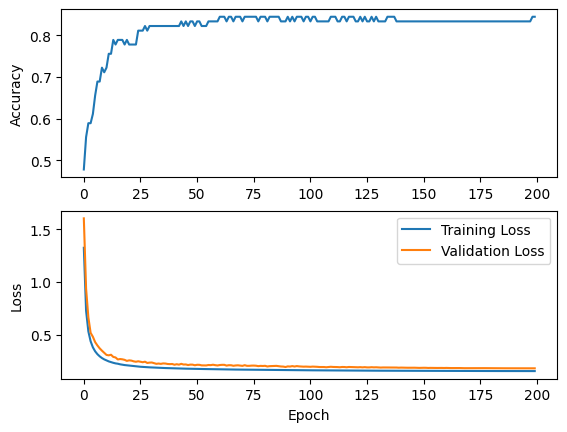

In [23]:
# Define number of input features, hidden layers, and output features
num_inputs = X_train.shape[1]
num_hidden = [15,8]
num_outputs = 1

# Initialize the model
model = init_model(num_inputs, num_hidden, num_outputs)

print(model)
print(f"Parameters: {len(model.parameters())}")

# Define the training parameters
batch_size = 100
num_epochs = 200

# Train the model
train_losses, validate_losses, validate_accuracy = train_model(
    model,
    (X_train, y_train),
    (X_validate, y_validate),
    num_epochs=num_epochs,
    batch_size=batch_size,
)

# Plot the results
plt.subplot(211)
plt.ylabel('Accuracy')
plt.plot(validate_accuracy, label='Accuracy')

plt.subplot(212)
plt.ylabel('Loss')
plt.plot(train_losses, label='Training Loss')
plt.plot(validate_losses, label='Validation Loss')
plt.legend()
plt.xlabel("Epoch")

In [24]:
# Input features from the scaled test dataset
test_features = test_scaled_df.to_numpy()

# Forward full test set
test_output = forward(model, test_features)
test_output_binary = [1 if x.data > 0.5 else 0 for x in test_output]

# Create submission dataframe
submission_df = pd.DataFrame(test_output_binary, index=test_df.index, columns=["Survived"])
submission_df.to_csv("submission.csv")

submission_df.head(10)

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
897,0
898,0
899,0
900,1
